In [1]:
import pickle
import os
import pandas as pd

output_dir = "outputs"
splitted_docs = pickle.load(open(os.path.join(output_dir, "split_docs.pkl"), 'rb'))
qa_df = pd.read_json(os.path.join(output_dir, "qa.json"), lines=True)

In [2]:
from langchain.embeddings import init_embeddings
from langchain.chat_models import init_chat_model
from langchain_chroma import Chroma
import dotenv
import os
dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("API_KEY", "")
os.environ["OPENAI_BASE_URL"] = os.getenv("BASE_URL", "")

embeddings = init_embeddings(
    model="openai:text-embedding-3-small",
)

vector_db = Chroma.from_documents(
    documents=splitted_docs,
    persist_directory= os.path.join(output_dir, 'chromadb_v1'),
    embedding=embeddings
)
retriver = vector_db.as_retriever(search_kwargs={'k': 8})
llm = init_chat_model(
    model='openai:gpt-4o-mini',
    temperature = 0.8,
    top_p = 0.85
)


/Users/yuke/github/llm-learning/langchain/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing_extensions import List

class Query(BaseModel):
    queries: List[str] = Field([], description="生成三个类似的问题, 并且把原始问题放在最开始，即四个字符串的列表")

query_parser = PydanticOutputParser(pydantic_object=Query)

query_prompt = PromptTemplate.from_template(
    template="给你一个问题：{query}, 请生成三个类似的问题，并且按照这个结构{format}输出答案",
    partial_variables={'format': query_parser.get_format_instructions()}
)

def get_list(response):
    return response.queries

chain = (
    query_prompt
    | llm
    | query_parser
    | get_list
)

chain.invoke({'query': '2024年中国经济展望'})


['2024年中国经济展望',
 '2024年中国的消费市场趋势如何？',
 '2024年中国的出口前景会受到哪些因素影响？',
 '2024年中国科技创新对经济增长的贡献如何？']

In [11]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
from langchain_core.load import loads, dumps
from collections import defaultdict
import time

def reciprocal_rank_fusion(results : list[list], k = 60):
    fused_scores = defaultdict(float)
    for docs in results:
        for rank, doc in enumerate(docs):
            temp = dumps(doc)
            fused_scores[temp] += 1 /(rank + k)
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return reranked_results[:8]

num_retrieve = 8
hit_state_data = []
retriver = vector_db.as_retriever(search_kwargs={'k' : 4})

def process_row(row):
    question = row['question']
    true_uuid = row['uuid']
    retries = 3
    delay = 1
    for i in range(retries):
        try:
            query_list = chain.invoke(question)
            docs_list = retriver.batch(query_list)
            reranked_results = reciprocal_rank_fusion(docs_list)
            uuids = [doc.metadata['uuid'] for doc, score in reranked_results]
            hits = []
            for i in range(1, num_retrieve + 1):
                hits.append({
                    'question': question,
                    'top_k': i,
                    'hit': true_uuid in uuids[:i]
                })
            return hits
        except Exception as exc:
            if i < retries - 1:
                time.sleep(delay)
                delay *= 2
            else:
                raise exc     
    return []

with ThreadPoolExecutor(max_workers=16) as excecutor:
    futures = [excecutor.submit(process_row, row) for idx, row in qa_df.iterrows()]
    for future in tqdm(as_completed(futures), total=len(qa_df)):
        hit_state_data.extend(future.result())

rag_fusion_df = pd.DataFrame(hit_state_data)

100%|██████████| 401/401 [02:01<00:00,  3.29it/s]


In [12]:
rag_fusion_hit = rag_fusion_df.groupby('top_k')['hit'].mean().reset_index()
data = [
    {'top_k': 1, 'hit': 0.405},
    {'top_k': 2, 'hit': 0.580},
    {'top_k': 3, 'hit': 0.665},
    {'top_k': 4, 'hit': 0.715},
    {'top_k': 5, 'hit': 0.755},
    {'top_k': 6, 'hit': 0.795},
    {'top_k': 7, 'hit': 0.840},
    {'top_k': 8, 'hit': 0.855}
]
base = pd.DataFrame(data)
rag_fusion_hit['dataset'] = 'rag_fusion'
base['dataset'] = 'baseline'

concat_df = pd.concat([rag_fusion_hit,base], ignore_index=True)
print(concat_df)


    top_k       hit     dataset
0       1  0.463840  rag_fusion
1       2  0.653367  rag_fusion
2       3  0.733167  rag_fusion
3       4  0.795511  rag_fusion
4       5  0.835411  rag_fusion
5       6  0.850374  rag_fusion
6       7  0.862843  rag_fusion
7       8  0.867830  rag_fusion
8       1  0.405000    baseline
9       2  0.580000    baseline
10      3  0.665000    baseline
11      4  0.715000    baseline
12      5  0.755000    baseline
13      6  0.795000    baseline
14      7  0.840000    baseline
15      8  0.855000    baseline


<Axes: xlabel='top_k', ylabel='hit'>

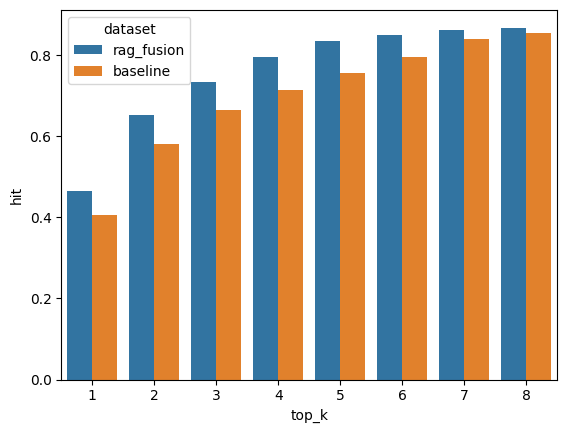

In [13]:
import seaborn as sns
sns.barplot(data = concat_df, hue='dataset', x='top_k', y='hit')